In [15]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Adjust output layer

    def forward(self, x):
        return self.model(x)

In [4]:
# Transformations: Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to fixed size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [5]:
# Caricamento del modello
model_path = './handwriting_model.pth'
#model = torch.load(model_path, map_location=torch.device('cpu'))
#model.eval()

# Load Dataset
data_dir = "./data"
dataset = ImageFolder(root=data_dir, transform=transform)

num_classes = len(dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = SimpleCNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("handwriting_model.pth", map_location=torch.device('cpu')))
model.eval()  # Modalità di valutazione

c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SimpleCNN(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data  # I dati sono già nel formato corretto (tensori di immagini)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]  # Ogni elemento è una tupla (immagine, etichetta)
        return image, label


In [ ]:
'''
# Carica il dataset da un file .pth
data = torch.load("val_dataset.pth") 

# Crea il dataset personalizzato
test_dataset = CustomDataset(data)

# Crea il DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize lists to store predictions and labels
all_labels = []
all_preds = []
all_probs = []

# Evaluate the model on the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to("cuda" if torch.cuda.is_available() else "cpu")
        labels = labels.to("cuda" if torch.cuda.is_available() else "cpu")

        # Get model predictions
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # For multi-class models
        _, preds = torch.max(probabilities, 1)

        # Store labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probabilities[:, 1].cpu().numpy())  # For binary classification
    
#Accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Compute metrics
precision = precision_score(all_labels, all_preds, average="weighted", labels=np.unique(all_preds))
recall = recall_score(all_labels, all_preds, average="weighted", labels=np.unique(all_preds))
f1 = f1_score(all_labels, all_preds, average="weighted", labels=np.unique(all_preds))

# ROC and AUC
#fpr, tpr, _ = roc_curve(all_labels, all_probs)
#roc_auc = auc(fpr, tpr)

# Genuine Acceptance Rate (GAR) and Genuine Rejection Rate (GRR)
#genuine_acceptance_rate = tpr[-1]  # GAR: last value of TPR in ROC
#genuine_rejection_rate = 1 - fpr[-1]  # GRR: complement of last FPR in ROC

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Return all metrics
print("Accuracy: " + str(accuracy),
    "\nPrecision: "+ str(precision),
    "\nRecall: " + str(recall),
    "\nF1 Score: " + str(f1),
    "\nConfusion Matrix: " + str(cm))
'''

Accuracy: 0.935064935064935 
Precision: 0.9274891774891774 
Recall: 0.935064935064935 
F1 Score: 0.9283549783549784 
Confusion Matrix: [[16  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  3]]


c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [58]:
'''
# Return all metrics
print("Precision: "+ str(precision),
    "\nRecall: " + str(recall),
    "\nF1 Score: " + str(f1),
    "\nConfusion Matrix: " + str(cm))
'''

Precision: 0.9274891774891774 
Recall: 0.935064935064935 
F1 Score: 0.9283549783549784 
Confusion Matrix: [[16  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  3]]


In [ ]:
'''
for batch in test_loader:
    print(f"Tipo: {type(batch)}, Lunghezza: {len(batch)}")
    for i, item in enumerate(batch):
        print(f"Elemento {i}: Tipo {type(item)}, Dimensioni: {item.size() if hasattr(item, 'size') else 'Non Tensor'}")
    break
'''

Tipo: <class 'list'>, Lunghezza: 2
Elemento 0: Tipo <class 'torch.Tensor'>, Dimensioni: torch.Size([32, 3, 128, 128])
Elemento 1: Tipo <class 'torch.Tensor'>, Dimensioni: torch.Size([32])


In [7]:
# Carica il dataset da un file .pth
data = torch.load("val_dataset.pth") 

# Crea il dataset personalizzato
test_dataset = CustomDataset(data)

# Crea il DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# Funzione per calcolare le metriche biometriche
def evaluate_model(model, test_loader):
    all_labels = []
    all_preds = []
    all_probs = []
    

    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    with torch.no_grad():
        for images, labels in test_loader:
            
            images, labels = images.to(device), labels.to(device)
            
            # Ottieni le predizioni e le probabilità
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probabilities, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.append(probabilities.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.vstack(all_probs)  # Convertire in array NumPy corretto

    test_classes = np.unique(all_labels)
    
    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
   
    # Precision, Recall, F1 Score
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

    
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels = test_classes)
   
    # FAR e FRR
    false_acceptance_rate = (np.sum(cm, axis=0) - np.diag(cm)) / np.sum(cm)
    
    false_rejection_rate = (np.sum(cm, axis=1) - np.diag(cm)) / np.sum(cm)
    
    # Binarizzazione delle etichette per la curva ROC multiclasse
    all_labels_bin = label_binarize(all_labels, classes=test_classes)
    
    fpr, tpr, roc_auc = {}, {}, {}
    
    for i, cls in enumerate(test_classes):
        # Se non ci sono esempi positivi per la classe i
        if np.sum(all_labels_bin[:, i]) == 0:
            print(f"Classe {cls} non presente nei dati reali, impostando valori NaN")
            fpr[cls], tpr[cls], roc_auc[cls] = [np.nan], [np.nan], np.nan
        else:
            fpr[cls], tpr[cls], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
            roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Calcolo Equal Error Rate (EER) medio gestendo NaN
    eer_list = []
    for cls in test_classes:
        if not np.isnan(fpr[cls]).all() and not np.isnan(tpr[cls]).all():
            eer_value = fpr[cls][np.nanargmin(np.abs(fpr[cls] - (1 - tpr[cls])))]
            eer_list.append(eer_value)

    eer = np.mean(eer_list) if eer_list else np.nan
    gar = np.nanmean([tpr[cls][-1] for cls in test_classes if not np.isnan(tpr[cls][-1])])
    grr = np.nanmean([1 - fpr[cls][-1] for cls in test_classes if not np.isnan(fpr[cls][-1])])
    
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "CM": cm,
        "FAR": false_acceptance_rate.tolist(),
        "FRR": false_rejection_rate.tolist(),
        "EER": eer,
        "ROC_AUC": roc_auc,
        "GAR": gar,
        "GRR": grr,
        "FPR": fpr,
        "TPR": tpr,
        "test_classes": test_classes
    }


# Calcolo delle metriche
metrics = evaluate_model(model, test_loader)


In [9]:
print("Classi nei dati reali:", np.unique(all_labels))
print("Classi nelle predizioni:", np.unique(all_preds))

NameError: name 'all_labels' is not defined

In [16]:
set(all_labels) - set(all_preds)

{8,
 22,
 37,
 57,
 108,
 111,
 156,
 170,
 203,
 240,
 250,
 324,
 356,
 362,
 428,
 473,
 478,
 621}

In [10]:
# Stampa dei risultati
print("Metriche di Valutazione:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Metriche di Valutazione:
Accuracy: 0.935064935064935
Precision: 0.9274891774891774
Recall: 0.935064935064935
F1_Score: 0.9283549783549784
CM: [[16  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  3]]
FAR: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0033783783783783786, 0.0, 0.0033783783783783786, 0.0033783783783783786, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0033783783783783786, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0033783783783783786, 0.0, 0.0, 0.0, 0.0033783783783783786, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0033783783783783786, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [16]:
#print(metrics["test_classes"])

# Creazione DataFrame per una stampa leggibile
cm_df = pd.DataFrame(metrics["CM"], index=metrics["test_classes"], columns=metrics["test_classes"])

print("Confusion Matrix:")
print(cm_df.to_string())  # Stampa tabellare chiara

Confusion Matrix:
     0    5    7    8    11   12   13   15   22   24   25   37   42   44   55   57   59   60   65   66   83   84   87   88   93   95   98   105  106  108  111  112  115  116  117  121  122  123  126  127  128  130  131  132  133  138  143  147  148  149  152  153  156  157  160  162  164  166  167  170  173  177  184  185  188  189  192  193  197  200  202  203  205  206  210  213  222  231  232  233  237  240  244  245  246  247  248  250  252  254  256  260  270  271  278  280  282  283  285  287  290  291  296  297  301  309  314  316  317  318  324  326  327  328  329  331  332  333  334  335  336  337  338  339  341  342  343  345  346  347  348  356  357  359  361  362  364  372  375  376  377  378  379  380  381  383  384  386  399  406  411  416  418  428  431  433  434  436  437  442  443  444  455  458  459  461  465  473  477  478  480  481  484  485  486  487  493  495  496  502  507  509  512  514  522  530  531  532  536  538  539  540  541  548  550  55

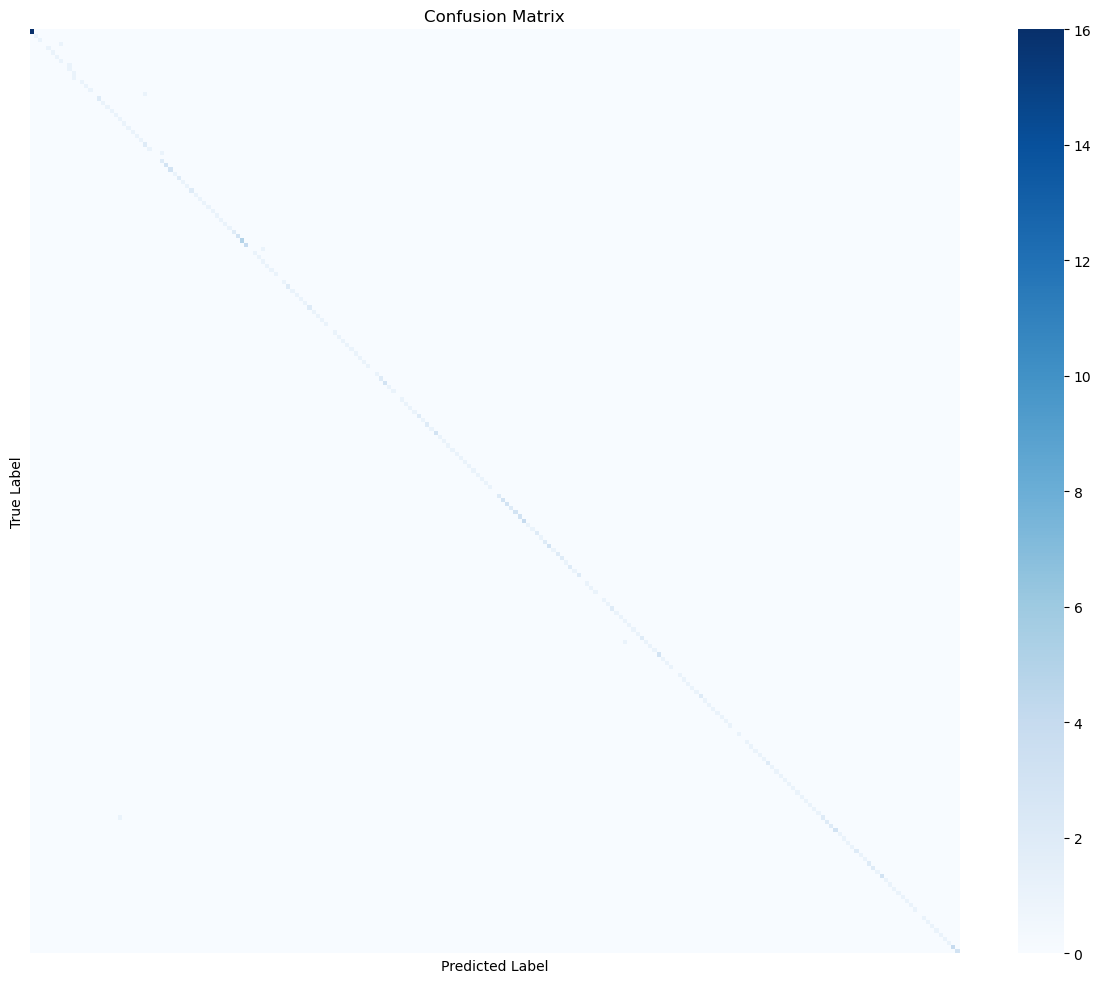

In [17]:
cm = metrics["CM"]
plt.figure(figsize=(15, 12))  # Adatta la dimensione per una matrice grande
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)  # Disattiva etichette per leggibilità
    
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


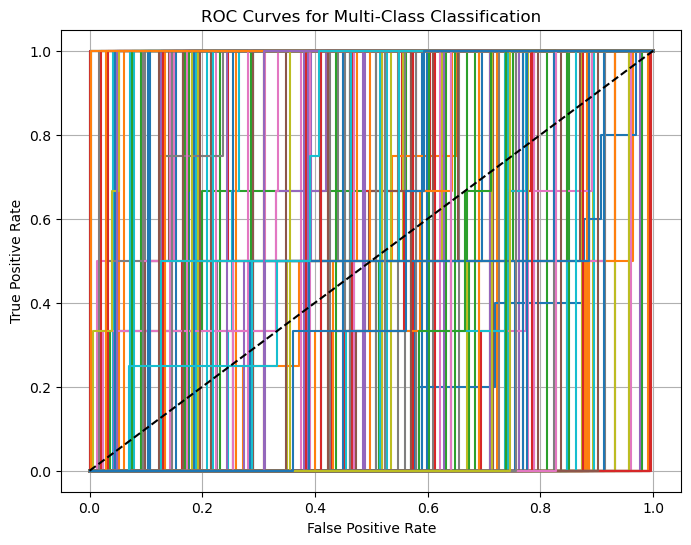

In [18]:
plt.figure(figsize=(8, 6))

test_classes = metrics["test_classes"]
roc_auc = metrics["ROC_AUC"]
fpr = metrics["FPR"]
tpr = metrics["TPR"]

# Plotta la curva ROC per ciascuna classe
for cls in test_classes:
    if not np.isnan(roc_auc[cls]):  # Evita classi senza esempi positivi
        plt.plot(fpr[cls], tpr[cls], label=f'Class {cls} (AUC = {roc_auc[cls]:.2f})')

# Linea diagonale per il caso random
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification")
#plt.legend(loc="lower right")
plt.grid()

plt.show()

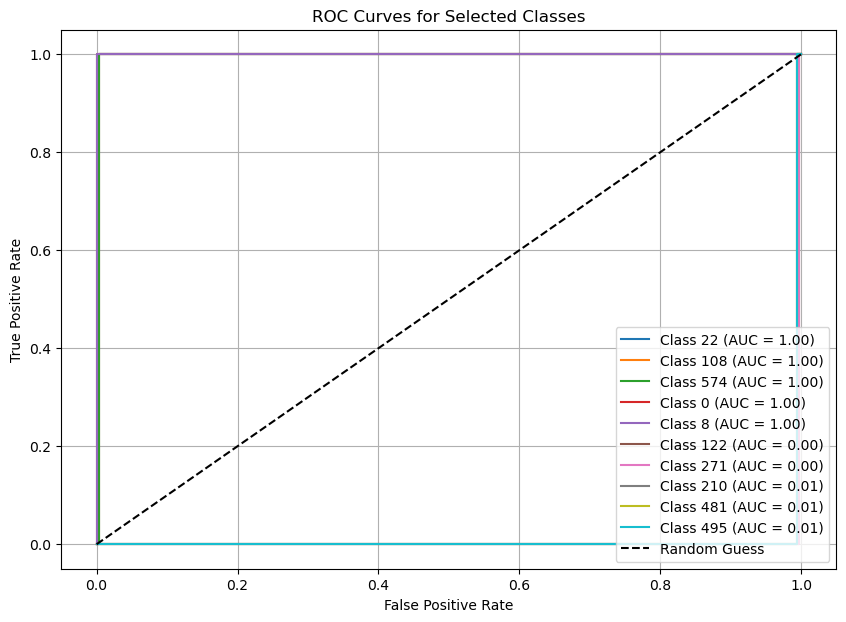

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

test_classes = metrics["test_classes"]
roc_auc = metrics["ROC_AUC"]
fpr = metrics["FPR"]
tpr = metrics["TPR"]

# Ordiniamo le classi in base all'AUC
sorted_classes = sorted(test_classes, key=lambda cls: roc_auc[cls] if not np.isnan(roc_auc[cls]) else -1)

# Selezioniamo le 5 migliori e peggiori classi
best_classes = sorted_classes[-5:]   # Top 5 AUC
worst_classes = sorted_classes[:5]   # Bottom 5 AUC
selected_classes = best_classes + worst_classes

# Plotta solo le curve selezionate
for cls in selected_classes:
    plt.plot(fpr[cls], tpr[cls], label=f'Class {cls} (AUC = {roc_auc[cls]:.2f})')

# Linea diagonale (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Selected Classes")
plt.legend(loc="lower right")
plt.grid()
plt.show()

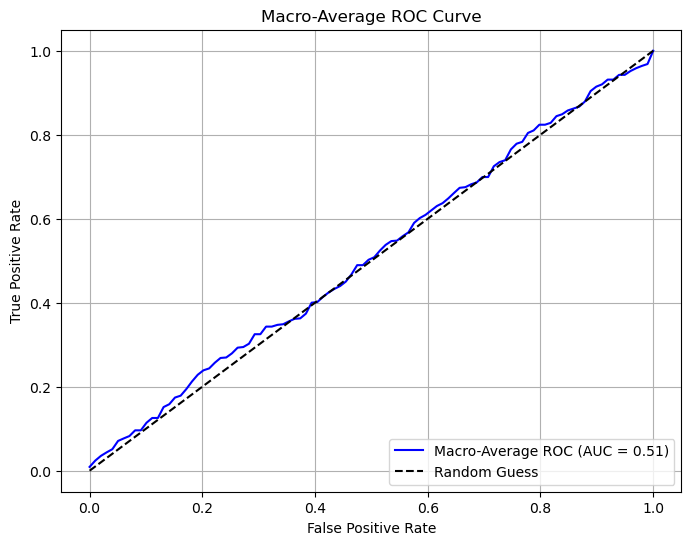

In [20]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

# Lista per memorizzare tutti i valori di FPR e TPR
all_fpr = np.linspace(0, 1, 100)  # Intervallo standard per interpolazione
mean_tpr = np.zeros_like(all_fpr)

# Calcoliamo la media delle curve ROC
valid_classes = [cls for cls in test_classes if not np.isnan(roc_auc[cls])]
for cls in valid_classes:
    mean_tpr += np.interp(all_fpr, fpr[cls], tpr[cls])  # Interpola i valori di TPR

mean_tpr /= len(valid_classes)  # Media

# Calcoliamo l'AUC medio
mean_auc = auc(all_fpr, mean_tpr)

# Plottiamo solo la curva media
plt.plot(all_fpr, mean_tpr, label=f'Macro-Average ROC (AUC = {mean_auc:.2f})', color="blue")

# Linea diagonale
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Average ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


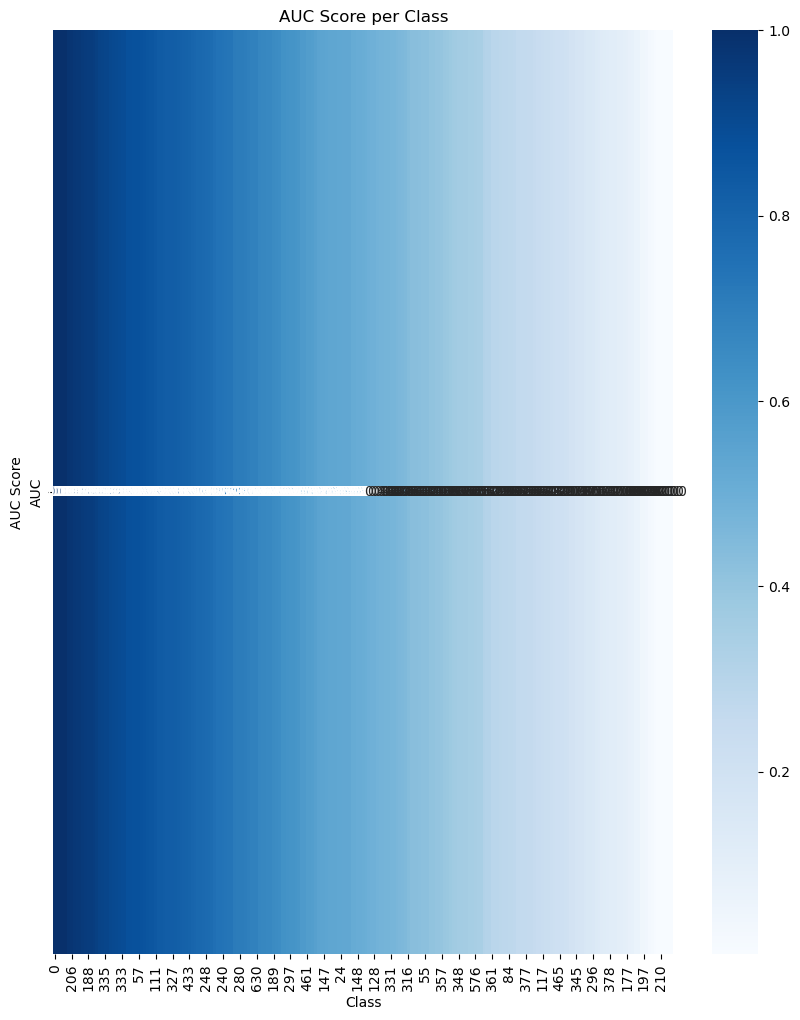

In [21]:
import seaborn as sns
import pandas as pd

# Creiamo un DataFrame con le classi e i loro AUC
auc_df = pd.DataFrame({"Class": test_classes, "AUC": [roc_auc[cls] for cls in test_classes]})
auc_df = auc_df.sort_values(by="AUC", ascending=False)  # Ordiniamo per AUC

plt.figure(figsize=(10, 12))
sns.heatmap(auc_df.set_index("Class").T, cmap="Blues", annot=True, fmt=".2f")

plt.title("AUC Score per Class")
plt.xlabel("Class")
plt.ylabel("AUC Score")
plt.show()


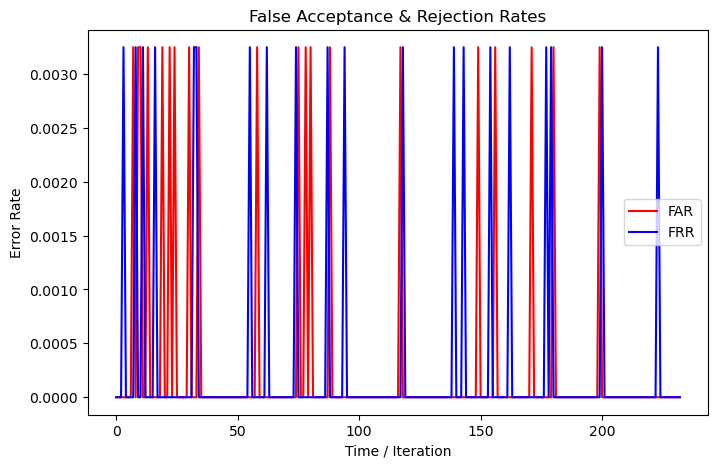

In [54]:
plt.figure(figsize=(8,5))
plt.plot(metrics["FAR"], label="FAR", color="red")
plt.plot(metrics["FRR"], label="FRR", color="blue")
plt.xlabel("Time / Iteration")
plt.ylabel("Error Rate")
plt.title("False Acceptance & Rejection Rates")
plt.legend()
plt.show()

C:\Users\Giuseppe\AppData\Local\Temp\ipykernel_12460\3322861868.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_labels, y=metrics_values, palette="viridis")


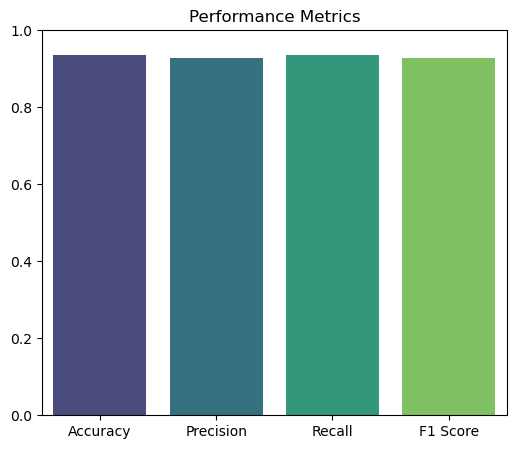

In [55]:
metrics_labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
metrics_values = [metrics["Accuracy"], metrics["Precision"], metrics["Recall"], metrics["F1_Score"]]

plt.figure(figsize=(6,5))
sns.barplot(x=metrics_labels, y=metrics_values, palette="viridis")
plt.ylim(0, 1)  # Limita da 0 a 1
plt.title("Performance Metrics")
plt.show()